Epoch 1/200


c:\Users\emada\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0806 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0099 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0032 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0032 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020 - val_loss: 0.0038 - learning_rate: 5.0000e-04
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020 - val_loss: 0.0054 - learning_rate: 5.0000e-04
Epoch 10/200
2

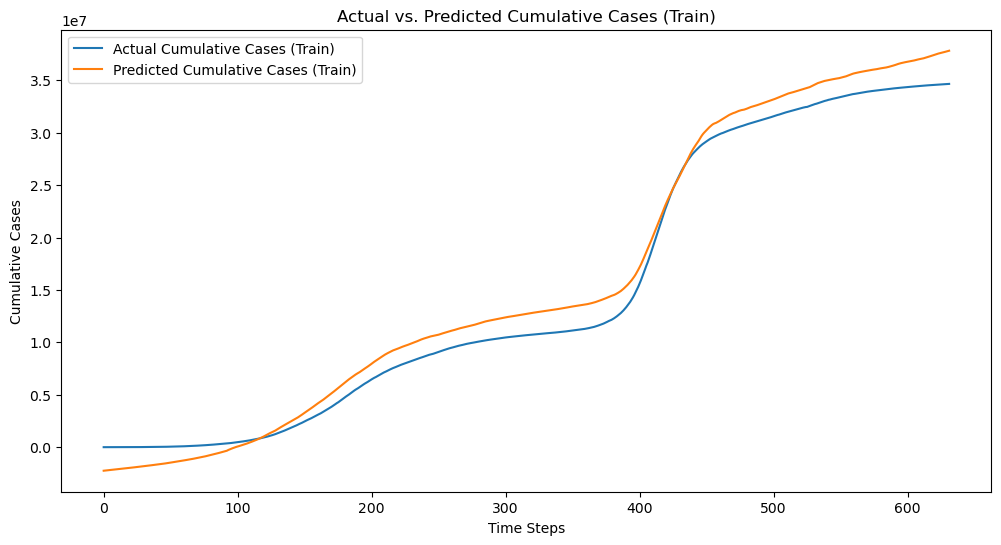

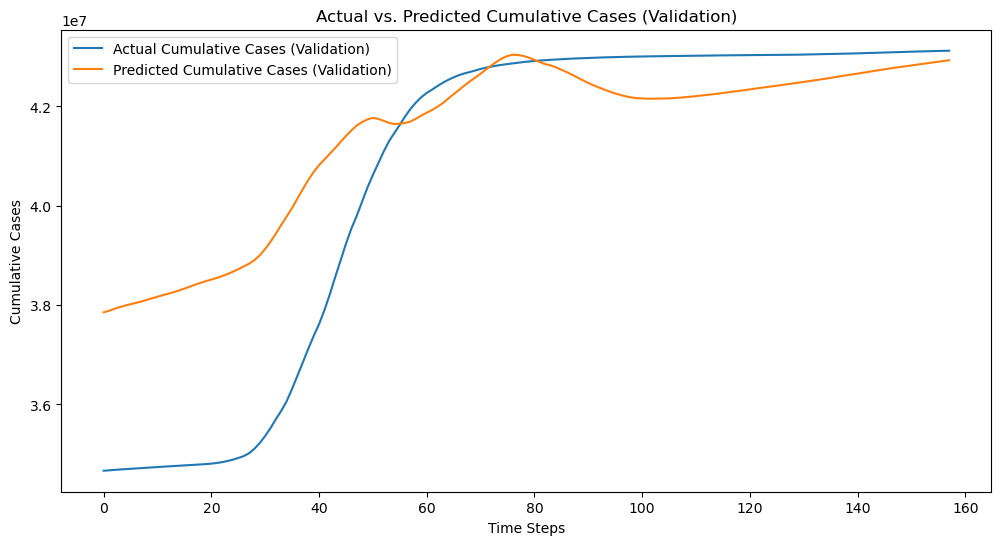

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the dataset
data = pd.read_csv('worldometer_coronavirus_daily_data.csv')

# Filter data for India
india_data = data[data['country'] == 'India'].copy()

# Handle missing values by forward filling and then filling any remaining NaNs with zeros
india_data.ffill(inplace=True)
india_data.fillna(0, inplace=True)

# Convert the 'date' column to datetime format
india_data['date'] = pd.to_datetime(india_data['date'], errors='coerce')

# Drop any rows where 'date' conversion failed
india_data.dropna(subset=['date'], inplace=True)

# Sort by date to maintain sequential order
india_data.sort_values('date', inplace=True)
india_data.reset_index(drop=True, inplace=True)

# Convert the date to a numerical value (days since the first date)
india_data['date'] = (india_data['date'] - india_data['date'].min()).dt.days

# Create rolling averages to smooth out the daily fluctuations
india_data['daily_new_cases_avg'] = india_data['daily_new_cases'].rolling(window=7).mean().fillna(0)
india_data['daily_new_deaths_avg'] = india_data['daily_new_deaths'].rolling(window=7).mean().fillna(0)

# Selecting relevant features for training and target column
features = ['date', 'daily_new_cases_avg', 'active_cases', 'cumulative_total_deaths', 'daily_new_deaths_avg']
target = 'cumulative_total_cases'

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
india_data[features] = scaler.fit_transform(india_data[features])

# Scale the target variable
target_scaler = MinMaxScaler()
india_data[[target]] = target_scaler.fit_transform(india_data[[target]])

# Ensure the target variable does not contain NaNs or infinities
india_data[target].replace([np.inf, -np.inf], np.nan, inplace=True)
india_data.dropna(subset=[target], inplace=True)

# Create sequences for supervised learning
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 30
X, y = create_sequences(india_data, seq_length)

# Split data into training and validation sets (first 80% for training)
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Build a Bidirectional GRU model
model = Sequential([
    Bidirectional(GRU(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Predict on both training and validation sets
y_train_pred = model.predict(X_train).squeeze()
y_val_pred = model.predict(X_val).squeeze()

# Inverse scale the predictions and the true values
y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1)).squeeze()
y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).squeeze()
y_val = target_scaler.inverse_transform(y_val.reshape(-1, 1)).squeeze()
y_val_pred = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1)).squeeze()

# Calculate evaluation metrics for validation
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
r2 = r2_score(y_val, y_val_pred)

print(f'Mean Absolute Error (Validation): {mae}')
print(f'Root Mean Squared Error (Validation): {rmse}')
print(f'Mean Absolute Percentage Error (Validation): {mape}%')
print(f'R-squared (Validation): {r2}')

# Plot the actual vs. predicted cumulative cases for training data
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual Cumulative Cases (Train)')
plt.plot(y_train_pred, label='Predicted Cumulative Cases (Train)')
plt.title('Actual vs. Predicted Cumulative Cases (Train)')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Cases')
plt.legend()
plt.show()

# Plot the actual vs. predicted cumulative cases for validation data
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Cumulative Cases (Validation)')
plt.plot(y_val_pred, label='Predicted Cumulative Cases (Validation)')
plt.title('Actual vs. Predicted Cumulative Cases (Validation)')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Cases')
plt.legend()
plt.show()
